In [1]:
import pandas as pd
import numpy as np
import psamm
import cobra
from cobra.sampling import sample
from cobra.flux_analysis import flux_variability_analysis
from cameo import phenotypic_phase_plane
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import colors as mcolors
import seaborn as sns
import os
import sys
print("psamm version:", psamm.__version__)
print("cobra version:", cobra.__version__)
print("Python version:", sys.version)

psamm version: 1.2.1
cobra version: 0.29.1
Python version: 3.9.15 (main, Nov 24 2022, 14:31:59) 
[GCC 11.2.0]


This notebook contains code necessary to replicate the figures for the following paper:


> O’Quinn, Hailey, Jason Vailionis, Tania Tanwee, Katherine Holandez-Lopez, Ryan Bing, Farris Poole, Ying Zhang, Robert Kelly, and Michael Adams. 2025. “Engineering the Hyperthermophilic Archaeon Pyrococcus Furiosus for 1-Propanol Production.” Applied and Environmental Microbiology.

Running this notebook will create the following files in `GEM-iPfu/manuscript/OQuinn_2025/output`:
* "fig7_combined_panels.png"
    * Figure 7
* "free_energy_grids_subset.png"
    * Figure S6
* "free_energy_grids_full.png"
    * An expanded version of Figure S6 that was not included in the manuscript
* "exp_sample.csv"
    * Contains the flux sample dataframe used to generate figure 7
* "feasible_propanol_per_expFlux.tsv"
    * Data S1

In [2]:
def COM1_strain_setup(model, strain):
    """
    This function will parse the strain names, each phrase (separated by space) at a time
    and will return a new model. All of the behaviors are hardcoded into here and it assumes 
    you are starting with a COM1 model.
    """
    # Set up needed reactions
    GAPN = {"C00001": -1, "C00006": -1, "C00118": -1, "C00005": 1, "C00080": 1, "C00197": 1}
    PPi_pfk = {"C00013": -1, "C00085": -1, "C00009": 1, "C05378": 1, "C00080": 1}
    ATP_pfk = {"C00002": -1, "C00085": -1, "C00008": 1, "C05378": 1}
    ATP_glk = {"C00002": -1, "C00031": -1, "C00008": 1, "C00092": 1}
    CODH = {"C00237": -1, "C00001": -1, "C01330_1": -1, "C00011": 1, "C00282": 1, "C01330": 1}
    TP_CO = {"C00237": -1, "C00237_1": 1}
    fhl = {"C00058": -1, "C01330_1": -1, "C00011": 1, "C01330": 1, "C00282": 1}
    ft = {"C00058_1": -1, "C00080_1": -1, "C00058": 1, "C00080": 1}
    CO_exchange = {"C00237_1": -1}
    HCO_exchange = {"C00058_1": -1}
    
    # Create a new model to work on
    m2 = model.copy()
    
    # Evaluate the strain name one word at a time
    # There is no switch statement in 3.9 :(
    for phrase in strain.split(" "):
        if phrase == "closed":
            m2.reactions.R00700.upper_bound = 1000
            m2.reactions.R07181.upper_bound = 1000
        elif phrase == "open":
            m2.reactions.R00700.upper_bound = 0
            m2.reactions.R07181.upper_bound = 0
        elif phrase == "COM1":
            pass
        elif phrase == "MW676":
            pass
        elif phrase == "MW670":
            pass
        elif phrase == "CODH":
            create_rxn(m2, "CODH", CODH, direction="forward")
            create_rxn(m2, "TP_CO", TP_CO, direction="both")
        elif phrase == "+CO":
            create_rxn(m2, "CO_exchange", CO_exchange, limits=(-1000, 0))
        elif phrase == "FDH":
            create_rxn(m2, "fhl", fhl, direction="forward")
            create_rxn(m2, "ft", ft, direction="forward")
        elif phrase == "+HCO":
            create_rxn(m2, "HCO_exchange", HCO_exchange, limits=(-1000, 0))
        elif phrase == "gapn":
            create_rxn(m2, "R01058", GAPN, direction="forward")
        elif phrase == "Δgapor::gapn":
            m2.remove_reactions(["R07159"])
            create_rxn(m2, "R01058", GAPN, direction="forward")
        elif phrase == "PPi-pfk":
            create_rxn(m2, "PPi_pfk", PPi_pfk, direction="forward")
        elif phrase == "ΔADP-pfk::PPi-pfk":
            m2.remove_reactions(["R05805"])
            create_rxn(m2, "PPi_pfk", PPi_pfk, direction="forward")
        elif phrase == "ΔADP-pfk::ATP-pfk":
            m2.remove_reactions(["R05805"])
            create_rxn(m2, "ATP_pfk", ATP_pfk, direction="forward")
        elif phrase == "ΔADP-glk::ATP-glk":
            m2.remove_reactions(["R05804"])
            create_rxn(m2, "ATP_glk", ATP_glk, direction="forward")
        
    return m2
def create_rxn(model, name, cpd_dict, direction="both", limits=None):
    # Create a reaction from a dict with {"CPD1": -1, "CPD2: 1"}
    # Assuming the cpd ids are already in the model
    if direction not in ["forward", "reverse", "both"]:
        raise ValueError("Direction must be either forward, reverse, or both")
    rxn = cobra.Reaction(name)
    if limits is not None:
        if len(limits) != 2:
            raise ValueError("Limits must be of length 2")
        else:
            rxn.lower_bound = limits[0]
            rxn.upper_bound = limits[1]
    elif direction == "both":
        rxn.lower_bound = -1000
        rxn.upper_bound = 1000
    elif direction == "forward":
        rxn.lower_bound = 0
        rxn.upper_bound = 1000
    else:
        rxn.lower_bound = -1000
        rxn.upper_bound = 0
    rxn.add_metabolites({
        getattr(model.metabolites, cpd): val for cpd, val in cpd_dict.items()
    })
    print("Adding the following reaction to model:")
    print(rxn)
    model.add_reactions([rxn])
def add_fixed_constraint(model, rxn, value):
    """
    model = cobra formatted model
    rxn = string of reaction id
    value = a single int/float to constrain the reaction to, or a list/tuple like (lb, ub)
    """
    try:
        lower = value[0]
        upper = value[1]
    except (TypeError, IndexError):
        lower = value
        upper = value
    constraint = model.problem.Constraint(
        getattr(model.reactions, rxn).flux_expression,
        lb=lower, ub=upper)
    model.add_cons_vars(constraint)
    return constraint

# Initial model setup
Start with a model that has the propanol pathway  

3.5 g/L cellobiose

In [3]:
os.getcwd()

'/home/jason_vailionis_uri_edu/git/GEM-iPfu/manuscript/OQuinn_2025'

In [4]:
# Defining file paths to be used later
outdir = "./output"
carbon_closure_path = "./data/2023-07-06_propanol_carbon_balance.tsv"
full_model_path = "../../sbmls/51f3bbf9_propanol_FDH_CODH.sbml"

In [5]:
os.makedirs(outdir, exist_ok=True)

## Models to establish
* exp_model
    * everything in carbon_closure constrained
* base_model
    * cellobiose and protein constrained
* base_model_uncons_bio
    * cellobiose constrained

In [6]:
carbon_closure = pd.read_table(carbon_closure_path)
carbon_closure = carbon_closure.set_index("name")

In [7]:
full_model = cobra.io.read_sbml_model(full_model_path)
full_model.reactions.EX_yeast_extract_LSQBKT_e_RSQBKT_.lower_bound = -0.5
base_model = full_model.copy()
base_model.remove_reactions(["fhl", "ft", "TP_CO", "CODH"])

# constraints to remove GAP looping in sampling
base_model.reactions.R01063.upper_bound = 0
base_model.reactions.R01061.upper_bound = 0

# constraint to stop the glycolysis bypass using nucleotide degredation pathway
base_model.reactions.R01057.upper_bound = 0

# Add reaction to track net ACS flux
create_rxn(base_model, "ACS_monitor", {})
ACS_monitor = base_model.problem.Constraint(
    base_model.reactions.ACS_monitor.flux_expression - \
    (base_model.reactions.R00229.flux_expression + base_model.reactions.R00229_DASH_G.flux_expression),
    lb=0,
    ub=0)
base_model.add_cons_vars(ACS_monitor)

# Add reaction to track net alanine export and map it to carbon_closure
create_rxn(base_model, "ala_monitor", {})
ala_monitor = base_model.problem.Constraint(
    base_model.reactions.ala_monitor.flux_expression - \
    (base_model.reactions.ala_DASH_t.flux_expression - base_model.reactions.alaAGCS.flux_expression),
    lb=0,
    ub=0)
base_model.add_cons_vars(ala_monitor)
carbon_closure.loc["Alanine", "reaction"] = "ala_monitor"

# Add a proxy for EPS
create_rxn(base_model, "EPS_sink", {"C00031": -1}, direction="forward")
carbon_closure.loc["EPS", "reaction"] = "EPS_sink"

base_model_uncons_bio = base_model.copy()

'' is not a valid SBML 'SId'.


Adding the following reaction to model:
ACS_monitor:  <=> 
Adding the following reaction to model:
ala_monitor:  <=> 
Adding the following reaction to model:
EPS_sink: C00031 --> 


In [8]:
# Set constraints
strain = "MW670_value"
exp_model = base_model.copy()
leeway = 0.01      # proportion
for name, row in carbon_closure.iterrows():
    vary = np.abs(leeway*row[strain])
    limits = (row[strain]-vary, row[strain]+vary)
    if not pd.isnull(row["reaction"]):
        add_fixed_constraint(exp_model, row["reaction"], limits)
        if name == "Cellobiose":
            add_fixed_constraint(base_model, row["reaction"], limits)
            add_fixed_constraint(base_model_uncons_bio, row["reaction"], limits)
        if name == "protein":
            add_fixed_constraint(base_model, row["reaction"], limits)

In [9]:
flux_variability_analysis(base_model, "TP_propanol")

,minimum,maximum
TP_propanol,0.0,5.911168


# Figure 7 - comparing optimal flux ranges per reaction to their predicted experimental flux distributions

1. Calculate the minumum and maximum amount of propanol possible when each reaction is constrained in 40 steps of all its possible values. 
2. Sample flux distributions from the experimentally-constrained model
3. Using the fva outputs, calculate the maximum amount of propanol that was feasible when each reaction was at its experimental-predicted median flux

In [10]:
base_model2 = base_model.copy()

In [11]:
fva_res = flux_variability_analysis(base_model)

a = sum([x.startswith("EX_") for x in fva_res.index])

b = sum([not x.startswith("EX_") for x in fva_res[(fva_res.round(7).minimum == 0) & (fva_res.round(7).maximum == 0)].index])

c = sum([not x.startswith("EX_") for x in fva_res[((fva_res.round(7).minimum != 0) & (fva_res.round(7).maximum != 0)) &
    (fva_res.round(7).minimum == fva_res.round(7).maximum)].index])

print(f"Exchange rxns: {a}\nBlocked reactions: {b}\nFixed reactions: {c}")

Exchange rxns: 77
Blocked reactions: 267
Fixed reactions: 140


In [12]:
target_rxns = fva_res[
    (fva_res.round(7).minimum != fva_res.round(7).maximum) & 
    [not x.startswith("EX_") for x in fva_res.index]].index.to_list()

In [13]:
len(target_rxns)

283

In [14]:
# FVA to calculate propanol bounds with each reaction constrained in 40 steps from its min to max
points = 40
dfs = []
for x in np.linspace(*flux_variability_analysis(base_model2, ["TP_propanol"]).values[0], points):
    c = add_fixed_constraint(base_model2, "TP_propanol", x)
    df = flux_variability_analysis(base_model2, target_rxns)
    base_model2.remove_cons_vars([c])
    #df = df.reset_index().melt(id_vars=["index"], value_vars=["minimum", "maximum"])
    df = df.reset_index()
    df["propanol"] = x
    dfs.append(df)
df_comb = pd.concat(dfs)
df_comb["minProp"] = df_comb["minimum"]/df_comb.groupby("index")["maximum"].transform("max")
df_comb["maxProp"] = df_comb["maximum"]/df_comb.groupby("index")["maximum"].transform("max")
df_comb = df_comb.fillna(0)
df_comb = df_comb.sort_values(["propanol", "index"])

In [15]:
# Flux sampling the experimentally-constrained model
s_exp = sample(exp_model, 5000, processes=8, seed=12)
s_exp = s_exp[sorted(s_exp.columns)]
s_exp.to_csv(os.path.join(outdir, "exp_sample.csv"))

In [16]:
# Loading the saved sample later
s_exp = pd.read_csv(os.path.join(outdir, "exp_sample.csv"), index_col=0)

In [17]:
# Parsing through the fva results to find the max amount of propanol that was
# feasible when a reaction's flux was at its experimental median
output = []
for r in set(df_comb["index"]):
    x = s_exp.median().round(7)[r]
    df_comb_subset = df_comb.round(7).query(f"index == '{r}'")
    # The normal calculation breaks for reactions that are perfectly correlated with propanol
    if np.all((df_comb_subset["propanol"]/df_comb_subset["minimum"]).dropna() == 1):
        y = x
    else:
        y = df_comb_subset.query("(@x >= minimum) & (@x <= maximum)")["propanol"].max()
    output.append([r, x, y])

In [18]:
df_propanol_allowed = pd.DataFrame(output, columns=["reaction", "median_flux", "max_propanol"])
df_propanol_allowed = df_propanol_allowed.sort_values("max_propanol")
df_propanol_allowed["name"] = [getattr(base_model.reactions, r).name for r in df_propanol_allowed["reaction"]]
df_propanol_allowed = df_propanol_allowed[["reaction", "name", "median_flux", "max_propanol"]]
df_propanol_allowed = df_propanol_allowed.dropna()
df_propanol_allowed.to_csv(os.path.join(outdir, "feasible_propanol_per_expFlux.tsv"), sep="\t", index=False)

In [19]:
df_propanol_allowed.query("max_propanol < 2")

,reaction,name,median_flux,max_propanol
132,AdhA_Propanol,NADP-dependent propanol dehydrogenase,0.398469,0.398469
149,AOR_Propionate,Propionaldehyde:ferredoxin oxidoreductase,0.398469,0.398469
15,TP_propanol,Propanol diffusion,0.398469,0.398469
173,hco3,none-enzymatic reaction of CO2 to HCO3-,1.183636,0.909410
48,R00920,Propanoate:CoA ligase (ADP-forming),1.025291,1.025291
46,R00740,3-oxopropanoate:NADP+ oxidoreductase (CoA-malo...,1.036606,1.036606
34,R01608_kz,3-hydroxypropanoate:NADP+ oxidoreductase,1.036606,1.036606
74,R03045,3-hydroxypropionyl-CoA dehydratase,1.036606,1.036606
268,R00919,acrylyl-CoA reductase (NADPH),1.036606,1.036606
26,R00742,acetyl-CoA:carbon-dioxide ligase (ADP-forming),1.036606,1.036606


/tmp/ipykernel_2619246/295785523.py:27: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_comb_subset.loc[:, "index"] = pd.Categorical(
/tmp/ipykernel_2619246/295785523.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(labels, rotation=90)


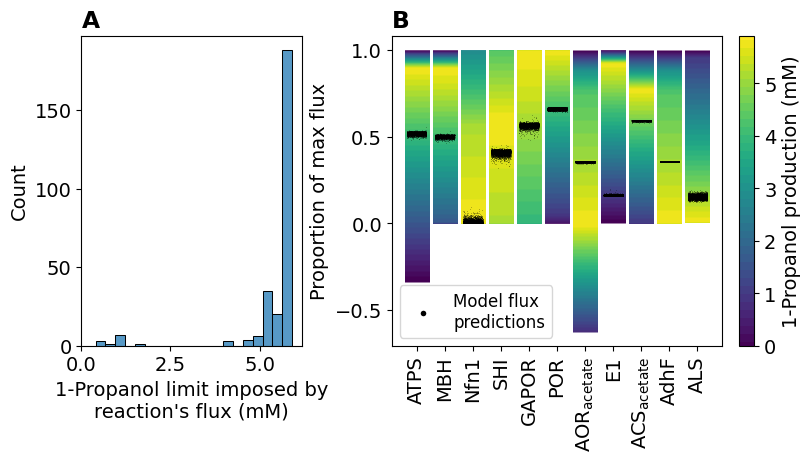

In [20]:
# Create a two-panel figure with specified width ratios and total width of 8 inches
with plt.rc_context({"figure.figsize": (8, 4.5), "font.size": 14,
                     "axes3d.grid": False, "legend.fontsize": 12}):

    fig, axes = plt.subplots(1, 2, gridspec_kw={'width_ratios': [0.4, 0.6]}, constrained_layout=True)

    # First panel: histogram plot
    ax1 = axes[0]
    sns.histplot(df_propanol_allowed, x="max_propanol", bins=20, ax=ax1)
    ax1.set_xlabel("1-Propanol limit imposed by\nreaction's flux (mM)")
    ax1.set_xlim(0)
    ax1.set_title("A", loc="left", weight="bold")

    # Second panel: strip and line plot
    ax2 = axes[1]
    targets = {
        "mbh": "MBH", "atps": "ATPS", "R07181": "SHI",
        "R00746": "AdhF", "R00742": "E1", "R01196": "POR",
        "R00226": "ALS", "R07159": "GAPOR", "nfn1": "Nfn1",
        "ACS_monitor": "ACS$_{\mathrm{acetate}}$", "AOR_acetaldehyde": "AOR$_{\mathrm{acetate}}$"
    }

    df_comb_subset = df_comb[[x in targets.keys() for x in df_comb["index"]]].copy()
    custom_order= ["atps", "mbh", "nfn1", "R07181", "R07159",
                   "R01196", "AOR_acetaldehyde", "R00742",
                   "ACS_monitor", "R00746", "R00226"]
    df_comb_subset.loc[:, "index"] = pd.Categorical(
        df_comb_subset["index"], 
        categories=custom_order, 
        ordered=True
    )
    df_comb_subset = df_comb_subset.sort_values(["propanol", "index"])
    jitter = 0.35
    pointsize = 0.3
    lw = 18
    norm = plt.Normalize()
    margin = 0.05
    colors = plt.colormaps["viridis"](norm(df_comb_subset.propanol))

    ax2.vlines(df_comb_subset["index"], df_comb_subset.minProp, df_comb_subset.maxProp, linewidth=lw, color=colors, alpha=1)
    labels = [targets[l.get_text()] for l in ax2.get_xticklabels()]
    ax2.set_xticklabels(labels, rotation=90)
    sns.stripplot(x="variable", y="value",
                  data=s_exp[target_rxns].div(df_comb_subset.groupby("index").max().maximum, axis=1).melt(),
                  alpha=1, s=pointsize, color="black", ax=ax2, jitter=jitter)
    ax2.set_xlabel(None)
    ax2.set_ylabel("Proportion of max flux")
    ax2.margins(x=margin)
    ax2.set_title("B", loc="left", weight="bold")

    # Add a legend entry for scatter points
    scatter_legend = Line2D([], [], marker="o", markerfacecolor="black",
                            markersize=4, label="Model flux\npredictions", linestyle="None",
                            markeredgewidth=0)
    ax2.legend(handles=[scatter_legend], loc="lower left")

    # Add colorbar
    cmap = mcolors.ListedColormap(colors)
    cbar = plt.colorbar(mappable=plt.cm.ScalarMappable(cmap=cmap), ax=ax2,
                        orientation="vertical", values=df_comb_subset.propanol, 
                        label="1-Propanol production (mM)")

    # Save the combined figure
    plt.savefig(os.path.join(outdir, "fig7_combined_panels.png"), dpi=300, bbox_inches="tight")
    plt.show()

# Figure S6 - free energy grids
Supply balanced reactions that allow the cell to freely replenish ATP/Reduced ferredoxin/NADH/NADPH/PPi. Constrain the fluxes of these reactions in increasing amounts in a grid and plot how the maximum propanol is affected.

In [21]:
atp_conversion = {"C00008": -1, "C00009": -1, "C00001": 1, "C00002": 1}
fed_conversion = {"C00139": -1, "C00138": 1, "C00080": 1}
nadh_conversion = {"C00003": -1, "C00080": 1, "C00004": 1}
nadph_conversion = {"C00006": -1, "C00001": -1, "C00080": 1, "C00005": 1}
ppi_source = {"C00013": 1}
free_PPi = {"C00009": -2, "C00001": 1, "C00013": 1}

limits = (0,30)
points = 40

rxn_map = {
    "free_ATP": ("Free ATP (mM)", atp_conversion),
    "free_Fd": ("Free FdRed (mM)", fed_conversion),
    "free_nadh": ("Free NADH (mM)", nadh_conversion),
    "free_nadph": ("Free NADPH (mM)", nadph_conversion),
    "free_ppi": ("Free PPi (mM)", free_PPi)
}

#model_map = {
#    "Base model": base_model
#}

target_strains = ["closed MW670", "closed MW670 PPi-pfk", "closed MW670 gapn PPi-pfk",
                  "open MW670", "open MW670 PPi-pfk", "open MW670 gapn PPi-pfk"]
model_map = {
    x: COM1_strain_setup(base_model, x) 
    for x in target_strains
}

## Only modify the options_to_test dict
## The keys should match the letters you decide to use when plotting below
## The values should match the keys of the rxn_map and model_map
options_to_test = {
    "A": ["closed MW670", "free_ATP", "free_nadph"],
    "B": ["closed MW670", "free_ATP", "free_ppi"],
    "C": ["closed MW670", "free_ppi", "free_nadph"],
    "D": ["closed MW670 PPi-pfk", "free_ATP", "free_nadph"],
    "E": ["closed MW670 PPi-pfk", "free_ATP", "free_ppi"],
    "F": ["closed MW670 PPi-pfk", "free_ppi", "free_nadph"],
    "G": ["closed MW670 gapn PPi-pfk", "free_ATP", "free_nadph"],
    "H": ["closed MW670 gapn PPi-pfk", "free_ATP", "free_ppi"],
    "I": ["closed MW670 gapn PPi-pfk", "free_ppi", "free_nadph"],
    "L": ["open MW670", "free_ATP", "free_nadph"],
    "M": ["open MW670", "free_ATP", "free_ppi"],
    "N": ["open MW670", "free_ppi", "free_nadph"],
    "O": ["open MW670 PPi-pfk", "free_ATP", "free_nadph"],
    "P": ["open MW670 PPi-pfk", "free_ATP", "free_ppi"],
    "Q": ["open MW670 PPi-pfk", "free_ppi", "free_nadph"],
    "R": ["open MW670 gapn PPi-pfk", "free_ATP", "free_nadph"],
    "S": ["open MW670 gapn PPi-pfk", "free_ATP", "free_ppi"],
    "T": ["open MW670 gapn PPi-pfk", "free_ppi", "free_nadph"]
}

output = []
for key, (model_name, x, y) in options_to_test.items():
        model_tmp = model_map[model_name].copy()
        create_rxn(model_tmp, x, rxn_map[x][1], direction="forward", limits=limits)
        create_rxn(model_tmp, y, rxn_map[y][1], direction="forward", limits=limits)
        p = phenotypic_phase_plane(model_tmp, [x, y],
                                   objective="TP_propanol", points=points)
        p_data = p.data_frame.query("not objective_upper_bound.isna()")[[x, y, "objective_upper_bound"]]
        p_data = p_data.rename(columns={x: "x_val", y: "y_val"})
        p_data["model"] = model_name
        p_data["x"] = x
        p_data["y"] = y
        output.append(p_data)

df_tmp = pd.concat(output).set_index(["model", "x", "y"])

Adding the following reaction to model:
PPi_pfk: C00013 + C00085 --> C00009 + C00080 + C05378
Adding the following reaction to model:
R01058: C00001 + C00006 + C00118 --> C00005 + C00080 + C00197
Adding the following reaction to model:
PPi_pfk: C00013 + C00085 --> C00009 + C00080 + C05378
Adding the following reaction to model:
PPi_pfk: C00013 + C00085 --> C00009 + C00080 + C05378
Adding the following reaction to model:
R01058: C00001 + C00006 + C00118 --> C00005 + C00080 + C00197
Adding the following reaction to model:
PPi_pfk: C00013 + C00085 --> C00009 + C00080 + C05378
Adding the following reaction to model:
free_ATP: C00008 + C00009 --> C00001 + C00002
Adding the following reaction to model:
free_nadph: C00001 + C00006 --> C00005 + C00080
Adding the following reaction to model:
free_ATP: C00008 + C00009 --> C00001 + C00002
Adding the following reaction to model:
free_ppi: 2 C00009 --> C00001 + C00013
Adding the following reaction to model:
free_ppi: 2 C00009 --> C00001 + C00013
Ad

In [22]:
strain_rename = {
    "closed MW670":                      r"$\mathrm{closed\ PROP}$",
    "closed MW670 gapn":                 r"$\mathrm{closed\ PROP\ } \it{gapn}$",
    "closed MW670 Δgapor::gapn":         r"$\mathrm{closed\ PROP\ } \Delta \it{gapor}\colon\colon\it{gapn}$",
    "closed MW670 PPi-pfk":              r"$\mathrm{closed\ PROP\ } \it{PPi{-}pfk}$",
    "closed MW670 gapn PPi-pfk":         r"$\mathrm{closed\ PROP\ } \it{gapn\ PPi{-}pfk}$",
    "closed MW670 Δgapor::gapn PPi-pfk": r"$\mathrm{closed\ PROP\ } \Delta \it{gapor}\colon\colon\it{gapn}\ \it{PPi{-}pfk}$",
    "closed MW670 CODH +CO":             r"$\mathrm{closed\ PROP\ } \it{codh} \ {+}\mathrm{CO}$",
    "closed MW670 FDH +HCO":             r"$\mathrm{closed\ PROP\ } \it{fdh} \ {+}\mathrm{HCO}$",
    "open MW670":                        r"$\mathrm{open\ PROP}$",
    "open MW670 gapn":                   r"$\mathrm{open\ PROP\ } \it{gapn}$",
    "open MW670 Δgapor::gapn":           r"$\mathrm{open\ PROP\ } \Delta \it{gapor}\colon\colon\it{gapn}$",
    "open MW670 PPi-pfk":                r"$\mathrm{open\ PROP\ } \it{PPi{-}pfk}$",
    "open MW670 gapn PPi-pfk":           r"$\mathrm{open\ PROP\ } \it{gapn\ PPi{-}pfk}$",
    "open MW670 Δgapor::gapn PPi-pfk":   r"$\mathrm{open\ PROP\ } \Delta \it{gapor}\colon\colon\it{gapn}\ \it{PPi{-}pfk}$",
    "open MW670 CODH +CO":               r"$\mathrm{open\ PROP\ } \it{codh} \ {+}\mathrm{CO}$",
    "open MW670 FDH +HCO":               r"$\mathrm{open\ PROP\ } \it{fdh} \ {+}\mathrm{HCO}$",
}

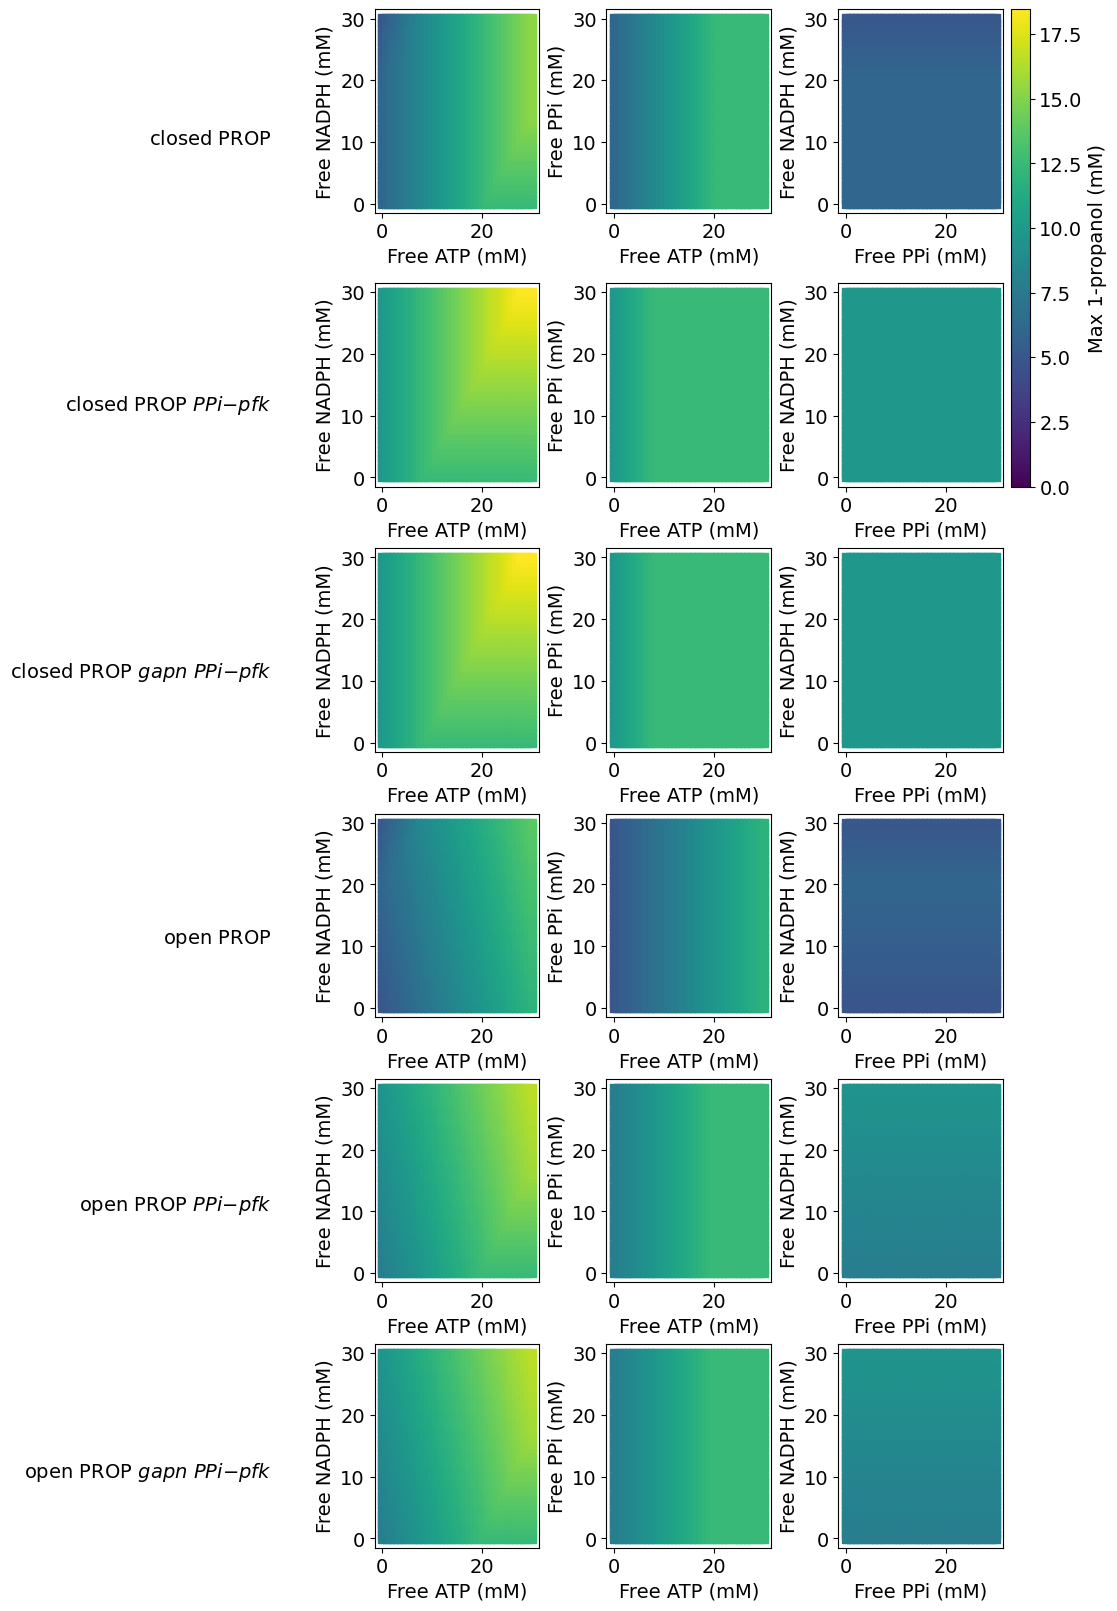

In [23]:
# This version includes plots that were not kept for the manuscript
with plt.rc_context({"figure.figsize": (8, 16), "font.size": 14,
                     "axes3d.grid": False}):

    fig, axes = plt.subplot_mosaic(
        """
        ABCp
        DEFp
        GHI.
        LMN.
        OPQ.
        RST.
        """,
        constrained_layout=True,
#        height_ratios=[1,1],
        width_ratios=[9, 9, 9, 1])
    
    cmap = "viridis"
    size = 35
    vmin = df_tmp["objective_upper_bound"].min()
    vmax = df_tmp["objective_upper_bound"].max()
    
    for key, (model_name, x, y) in options_to_test.items():
        df_subset = df_tmp.loc[model_name, x, y]
        sc = axes[key].scatter(df_subset["x_val"], df_subset["y_val"], c=df_subset["objective_upper_bound"],
                          cmap=cmap, s=size, marker="s", vmin=0, vmax=vmax)
        
        axes[key].set_xlabel(rxn_map[x][0])
        axes[key].set_ylabel(rxn_map[y][0])
    
    fig.colorbar(sc, cax=axes["p"], orientation="vertical", label="Max 1-propanol (mM)")
    
    # Strain name labels
    for i, label in enumerate(target_strains):
        fig.text(-0.05, 1 - (i + 0.5) / len(target_strains),
                 strain_rename[label], va="center", ha="right", rotation=0)
    
    plt.savefig(os.path.join(outdir, "free_energy_grids_full.png"),
                dpi=300, bbox_inches="tight")
    plt.show()

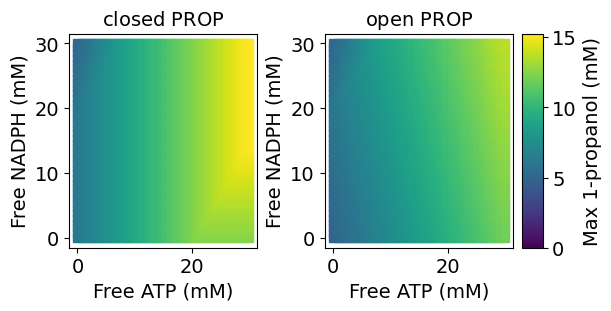

In [24]:
with plt.rc_context({"figure.figsize": (6, 3), "font.size": 14, "axes.titlesize": 14,
                     "axes3d.grid": False}):

    fig, axes = plt.subplot_mosaic(
        """
        ALp
        """,
        constrained_layout=True,
#        height_ratios=[1,1],
        width_ratios=[9, 9, 1])
    
    cmap = "viridis"
    size = 35
    vmin = df_tmp["objective_upper_bound"].min()
    #vmax = df_tmp["objective_upper_bound"].max()
    # Manually setting this for this particular subset
    vmax = df_tmp["objective_upper_bound"].loc["closed MW670", "free_ATP", "free_nadph"].max()
    
    options_to_test2 = {key: options_to_test[key] for key in ["A",
                                                              "L"]}
    for key, (model_name, x, y) in options_to_test2.items():
        df_subset = df_tmp.loc[model_name, x, y]
        sc = axes[key].scatter(df_subset["x_val"], df_subset["y_val"], c=df_subset["objective_upper_bound"],
                          cmap=cmap, s=size, marker="s", vmin=0, vmax=vmax)
        
        axes[key].set_xlabel(rxn_map[x][0])
        axes[key].set_ylabel(rxn_map[y][0])
        axes[key].set_title(strain_rename[options_to_test2[key][0]])
    
    # Manually doing this scaling for the subset..
    fig.colorbar(sc, cax=axes["p"], orientation="vertical", label="Max 1-propanol (mM)")
    
    plt.savefig(os.path.join(outdir, "free_energy_grids_subset.png"),
                dpi=300, bbox_inches="tight")
    plt.show()

In [25]:
# Example of querying the dataframe, which I used to find the approximate propanol value where
# adding more ATP stopped increasing propanol without adding more NADPH
df_tmp.loc["closed MW670", "free_ATP", "free_nadph"].query("y_val == 0")

x_val  y_val  objective_upper_bound
model        x        y                                                  
closed MW670 free_ATP free_nadph   0.000000    0.0               6.026525
                      free_nadph   0.769231    0.0               6.263211
                      free_nadph   1.538462    0.0               6.499897
                      free_nadph   2.307692    0.0               6.736584
                      free_nadph   3.076923    0.0               6.973270
                      free_nadph   3.846154    0.0               7.209957
                      free_nadph   4.615385    0.0               7.446643
                      free_nadph   5.384615    0.0               7.683329
                      free_nadph   6.153846    0.0               7.920016
                      free_nadph   6.923077    0.0               8.156702
                      free_nadph   7.692308    0.0               8.393388
                      free_nadph   8.461538    0.0               8.630075
                      free_nadph   9.230769    0.0               8.866761
                      free_nadph  10.000000    0.0               9.103448
                      free_nadph  10.769231    0.0               9.340134
                      free_nadph  11.538462    0.0               9.576820
                      free_nadph  12.307692    0.0               9.813507
                      free_nadph  13.076923    0.0              10.050193
                      free_nadph  13.846154    0.0              10.286880
                      free_nadph  14.615385    0.0              10.523566
                      free_nadph  15.384615    0.0              10.760252
                      free_nadph  16.153846    0.0              10.996939
                      free_nadph  16.923077    0.0              11.233625
                      free_nadph  17.692308    0.0              11.470312
                      free_nadph  18.461538    0.0              11.706998
                      free_nadph  19.230769    0.0              11.943684
                      free_nadph  20.000000    0.0              12.180371
                      free_nadph  20.769231    0.0              12.376682
                      free_nadph  21.538462    0.0              12.456503
                      free_nadph  22.307692    0.0              12.456503
                      free_nadph  23.076923    0.0              12.456503
                      free_nadph  23.846154    0.0              12.456503
                      free_nadph  24.615385    0.0              12.456503
                      free_nadph  25.384615    0.0              12.456503
                      free_nadph  26.153846    0.0              12.456503
                      free_nadph  26.923077    0.0              12.456503
                      free_nadph  27.692308    0.0              12.456503
                      free_nadph  28.461538    0.0              12.456503
                      free_nadph  29.230769    0.0              12.456503
                      free_nadph  30.000000    0.0              12.456503